In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [130]:
kharpov = False

In [264]:
if kharpov:
    true_params = {'theta': 0.50, 
               'pi': -7,
               'phi': -.3,
               'scale': .1,
               'delta': 1.11,
               'rho': .4,
              }
else:
     true_params ={'delta': 0.27,
                   'rho': 0.81,
                   'scale': 3.11,
                   'phi': -0.3,
                   'pi': -.1,
                   'theta': .5}
    
time_dim = 20000
sim_dim = 500
innov_dim = 50

In [265]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [266]:
vl.compute_gamma(**true_params)

0.10305489439653535

In [267]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.3,
 'pi': -0.1,
 'theta': 0.5,
 'gamma': 0.10305489439653535,
 'beta': 0.0976648421723812,
 'psi': -0.12644503261121254,
 'zeta': 0.91}

In [268]:
true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.3,
 'pi': -0.1,
 'theta': 0.5}

In [269]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.3,
 'pi': -0.1,
 'theta': 0.5,
 'gamma': 0.10305489439653535,
 'beta': 0.0976648421723812,
 'psi': -0.12644503261121254,
 'zeta': 0.91}

## We start by examining the distributions of simulated data

In [270]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [271]:
omega, omega_cov = vl.estimate_params(data)

In [272]:
omega

{'gamma': 0.10299575781933827,
 'beta': 0.09767541621860597,
 'psi': -0.12749901298749888,
 'zeta': 0.9191306042042894,
 'delta': 0.2563435988593038,
 'rho': 0.813143141072669,
 'scale': 3.2576831644925113}

In [273]:
omega_cov

,beta,delta,gamma,psi,rho,scale,zeta
beta,6.475482e-09,0.000000,-5.124831e-09,-5.328582e-09,0.000000,0.000000,0.000000
delta,0.000000e+00,0.000062,0.000000e+00,0.000000e+00,-0.000040,-0.000157,0.000000
gamma,-5.124831e-09,0.000000,1.830097e-08,1.027978e-09,0.000000,0.000000,0.000000
psi,-5.328582e-09,0.000000,1.027978e-09,1.029586e-05,0.000000,0.000000,0.000000
rho,0.000000e+00,-0.000040,0.000000e+00,0.000000e+00,0.000094,-0.000042,0.000000
scale,0.000000e+00,-0.000157,0.000000e+00,0.000000e+00,-0.000042,0.004905,0.000000
zeta,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000086


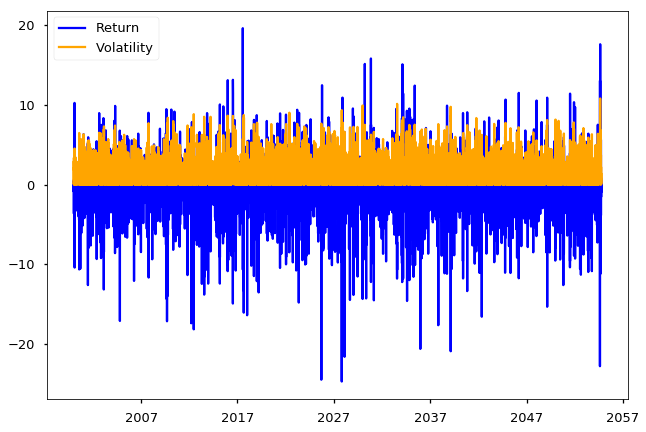

In [274]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [275]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,2.354271,-0.639262
rtn,-0.639262,4.552779


In [276]:
total_true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.3,
 'pi': -0.1,
 'theta': 0.5,
 'gamma': 0.10305489439653535,
 'beta': 0.0976648421723812,
 'psi': -0.12644503261121254,
 'zeta': 0.91}

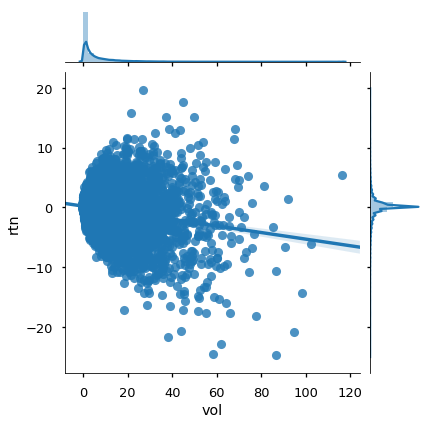

In [277]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [278]:
true_params['delta']

0.27

In [279]:
true_params['scale']

3.11

In [280]:
data.describe()

,vol,rtn
count,20000.000000,20000.000000
mean,4.466996,-0.030175
std,8.618722,2.133724
min,0.000010,-24.704542
25%,0.062825,-0.418414
50%,0.882581,0.125633
75%,4.717511,0.585490
max,116.293596,19.598735


## I now estimate all of the parameters

In [281]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [282]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [283]:
estimator(data_arr[0])

({'gamma': 0.10305064947917328,
  'beta': 0.09766252125817004,
  'psi': -0.1298620497244614,
  'zeta': 0.8983788780171559,
  'delta': 0.26173822108495987,
  'rho': 0.7993217544367138,
  'scale': 3.153668333716742,
  'phi': -0.3153407127120081,
  'pi': -0.09281920202677725,
  'theta': 0.497131207065102},
                beta     delta         gamma       phi        pi           psi  \
 beta   3.682292e-09  0.000000 -3.519742e-09       NaN       NaN -2.827458e-09   
 delta  0.000000e+00  0.000055  0.000000e+00       NaN       NaN  0.000000e+00   
 gamma -3.519742e-09  0.000000  1.658136e-08       NaN       NaN -5.060340e-10   
 phi             NaN       NaN           NaN  0.000187 -0.000127           NaN   
 pi              NaN       NaN           NaN -0.000127  0.000091           NaN   
 psi   -2.827458e-09  0.000000 -5.060340e-10       NaN       NaN  1.091006e-05   
 rho    0.000000e+00 -0.000033  0.000000e+00       NaN       NaN  0.000000e+00   
 scale  0.000000e+00 -0.000140  0.00000

In [284]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

Process ForkPoolWorker-49:
Process ForkPoolWorker-55:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-51:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-50:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sangrey/anacon

  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 293, in function_wrapper
    return function(*(wrapper_args + args))
  File "/home/sangrey/Dropbox/RiskPriceInference/volpriceinference/volprice.py", line 865, in compute_strong_id
    constraints=constraint_dict, bounds=bounds)
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 293, in function_wrapper
    return function(*(wrapper_args + args))
KeyboardInterrupt
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/sangrey/Dropbox/RiskPriceInference/volpriceinference/volprice.py", line 864, in <lambda>
    minimize_result = minimize(lambda x: _qlr_in(x, omega, omega_cov, case=case), x0=init, method='SLSQP',
  File "/home/sa

  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 293, in function_wrapper
    return function(*(wrapper_args + args))
  File "/home/sangrey/Dropbox/RiskPriceInference/volpriceinference/volprice.py", line 447, in compute_vol_gmm
    bounds=bounds)
KeyboardInterrupt
  File "/home/sangrey/Dropbox/RiskPriceInference/volpriceinference/volprice.py", line 446, in <lambda>
    initial_result = minimize(lambda x: compute_mean_square(x, vol_data, vol_moments), x0=x0, options=options,
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/slsqp.py", line 403, in _minimize_slsqp
    g = append(fprime(x), 0.0)
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py", line 603, in minimize
    callback=callback, **options)
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py", line 335, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/home/sangrey/Dropbox/RiskPrice

  File "/home/sangrey/Dropbox/RiskPriceInference/volpriceinference/volprice.py", line 410, in compute_mean_square
    func_data = np.mean(func(data, *x), axis=0)
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/slsqp.py", line 379, in _minimize_slsqp
    fx = func(x)
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/slsqp.py", line 63, in approx_jacobian
    jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 293, in function_wrapper
    return function(*(wrapper_args + args))
  File "/home/sangrey/Dropbox/RiskPriceInference/volpriceinference/volprice.py", line 352, in vol_moments
    return pd.DataFrame(np.squeeze(compute_vol_moments(x, y, rho, scale, delta)).T)
  File "/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 293, in function_wrapper
    return function(*(wrapper_args + args))
  File "/home/sangrey/Dro

KeyboardInterrupt
  File "/home/sangrey/Dropbox/RiskPriceInference/volpriceinference/volprice.py", line 610, in _qlr_in
    cov_pi = covariance_kernel(prices, prices, omega_cov=omega_cov, omega=omega, case=case)
KeyboardInterrupt


In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [ ]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [58]:
omega


{'gamma': 0.7657156356020306,
 'beta': 10.020785903040684,
 'psi': -0.14862081105261793,
 'zeta': 0.9064912605518765,
 'delta': 0.2839982925227206,
 'rho': 0.813499861491306,
 'scale': 3.1091614502542892}

In [59]:
true_params

{'delta': 0.27,
 'rho': 0.81,
 'scale': 3.11,
 'phi': -0.3,
 'pi': -0.36,
 'theta': 0.53}

In [60]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=10, alpha=None, robust_quantile=True)

In [61]:
total=min(50, len(est_arr))
with Pool(8) as pool:
    results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
                                                                                    est_arr[:total]),
                                                          total=total))))

ValueError: array must not contain infs or NaNs

In [ ]:
results[results <=0] = 0 

In [ ]:
results

In [ ]:
robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
                                    reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
fig, ax = mpl.pyplot.subplots()
cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='standard')
cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='robust')
ax.legend()
fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
else:
    filename = '../results/reject_prop_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
    
returnval.to_json(filename)

In [ ]:
returnval.head()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)